In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
""" Generate time series sequences and divides data to train,and test sets"""
def load_data(seq_len, shift_days = 1, normalize = True):
    
    result = []
    
    for index in range(len(data) - (seq_len+shift_days)):              # loop over all possible sequences by the sliding window
        result.append(data[index: index + seq_len + shift_days])       
    
    if normalize:
        result = normalise_windows(result)      # Normalizes one time series

    result = np.array(result)                   # convert list to array

    row = int(round(0.9 * result.shape[0]))   # 90% training data
    
    train = result[:row, :]                 # training set
    
    np.random.shuffle(train)
    
    x_train = train[:, :-shift_days]                # all the time series sequence except for last value for each seq           
    y_train = train[:, -shift_days:]                 # value following the end of the sliding window
    
    x_test = result[row:, :-shift_days]             # testing set
    y_test = result[row:, -shift_days:]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # reshape to 3d tensor for keras
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))     # reshape to 3d tensor for keras

    return x_train, y_train, x_test, y_test


In [3]:
""" Normalizes each windowed series of the data one at a time """
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def denormalise(window_data, p_0):
    denormalised_data = []
    for window in window_data:
        denormalised_window = [ (p_0 *(n+1)) for n in window]
        denormalised_data.append(denormalised_window)
    return denormalised_data

**Read Input Data**

  Effective date   S&P 500 (TR)  S&P 500 (Net TR)  S&P 500
0      2008-11-28       1437.68           1366.39   896.24
1      2008-12-01       1309.39           1244.44   816.21
2      2008-12-02       1361.79           1294.21   848.81
3      2008-12-03       1397.72           1328.14   870.74
4      2008-12-04       1356.81           1289.26   845.22


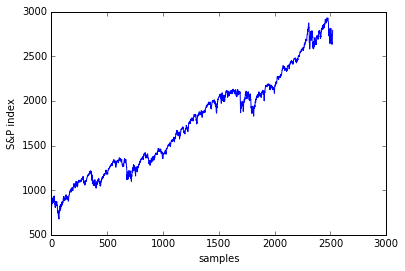

In [4]:
data  = pd.read_excel("data.xls", sheet_name= 'sheet2')    # reads excel to pandas dataframe
print(data.head())
data = np.array(data['S&P 500']).reshape(len(data),-1)    # Extract S&P column 
plt.plot(np.arange(len(data)),data)
plt.ylabel('S&P index')
plt.xlabel('samples')
plt.show()

In [5]:
print(len(data))

2521


In [6]:
seq_length = 50
x_train, y_train, x_test, y_test = load_data(seq_length, True)

**Visualizing Time series : Predicting one day to the future**

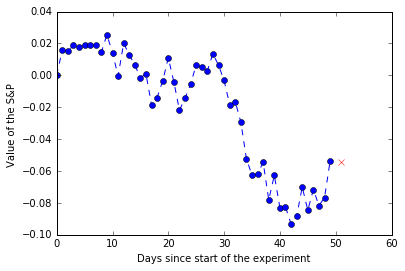

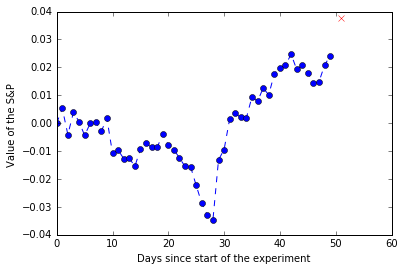

In [7]:

plt.plot(np.arange(seq_length), x_train[0, :], '--o')
plt.plot([seq_length + 1],y_train[0,:], 'rx')

plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the S&P ")
plt.show()

plt.plot(np.arange(seq_length), x_train[2, :], '--o')
plt.plot([seq_length + 1],y_train[2], 'rx')

plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the S&P ")
plt.show()

In [8]:
print("X train: ", x_train.shape)
print("Y train: ", y_train.shape)
print("X test: ", x_test.shape)
print("Y test: ", y_test.shape)

('X train: ', (2223, 50, 1))
('Y train: ', (2223, 1))
('X test: ', (247, 50, 1))
('Y test: ', (247, 1))


**LSTM Model**

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
model.add(Dense(1,kernel_initializer='uniform',activation='linear'))

model.compile(loss='mse',optimizer='adam',metrics=['mse'])
        
model.compile(loss='mse',optimizer='adam', metrics=['mse'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17 

In [10]:
#Step 3 Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=42,
    validation_split=0.05)

# 128 64 16 60

Instructions for updating:
Use tf.cast instead.
Train on 2111 samples, validate on 112 samples
Epoch 1/42
2111/2111 [==============================] - 7s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 7.5333e-04 - val_mean_squared_error: 7.5333e-04

**Training and validation losses**

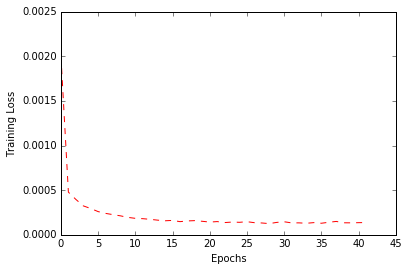

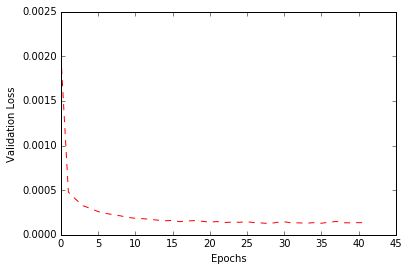

In [11]:
import keras
val_loss= history.history['val_loss']
train_loss= history.history['loss']
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
x = np.arange(len(train_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
x = np.arange(len(val_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

**Evaluate model on the testing set**

In [12]:
result = model.evaluate(x_test,y_test)
print("mean_squared_error: ", result[1])

247/247 [==============================] - 0s 911us/step
('mean_squared_error: ', 9.97246687865141e-05)


In [13]:
p = model.predict(x_test)

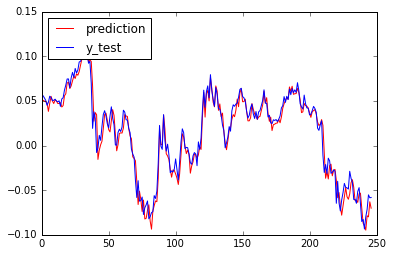

In [14]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

**Predict S&P index for the next five days**

In [15]:
from numpy import newaxis

days = 5                                         # Prediction length
x_before = data[-seq_length:]                                                 # Time series before predictions
p_0 = x_before[0]
x_before_normalized = np.array(normalise_windows([x_before]))
x_before_normalized = np.reshape(x_before_normalized,(x_before_normalized.shape[0], x_before_normalized.shape[1], 1)) # reshape to 3d tensor for keras
curr_frame = x_before_normalized[0]
pred_normal = []
pred = []
for i in range(days):
    p = model.predict(curr_frame[newaxis,:,:])[0,0]        # curr_frame[newaxis,:,:] converts it to 3d tensor
    pred_normal.append(p)                                  # normalized value                          
    curr_frame = curr_frame[1:]                            # shift frame by 1 
    curr_frame = np.insert(curr_frame, seq_length-1, pred_normal[-1], axis=0)  # append the predicted value to the shifted time series
    frame_denormal = np.array(denormalise(curr_frame ,p_0)).reshape(curr_frame.shape) # rescale curr frame
    pred.append(frame_denormal[-1])                                                   # predicted value rescaled
    curr_frame = np.array(normalise_windows(frame_denormal[newaxis,:,:])).reshape(curr_frame.shape)  # scale current frame again
    p_0 = frame_denormal[0]        # save the value of the denormalized frame for next iteration

In [16]:
for i in range (days): 
    print("Day ",i ," : ", pred[i])

('Day ', 0, ' : ', array([2771.80030873]))
('Day ', 1, ' : ', array([2758.15560909]))
('Day ', 2, ' : ', array([2744.39953328]))
('Day ', 3, ' : ', array([2733.26285344]))
('Day ', 4, ' : ', array([2723.29568638]))
